In [1]:
from model import SentimentClassifier,\
            SentimentClassifierMultiLinear,\
            SentimentClassifierUntrainedCLS,\
            SentimentClassifierUntrainedCLSMultiLastLayers,\
            SentimentClassifierUntrainedCLSMultiLastLayersMultiLinear

2024-02-26 12:10:47.948970: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-26 12:10:48.108084: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-26 12:10:48.923759: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/cuda/lib64:/opt/cuda/lib:/opt/cuda/lib64:/opt/cuda/lib
2024-02-26 12:10:48.923842: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dl

In [2]:
from data_preprocessing import MODEL_NAME, train_size, dev_size
from model import SentimentClassifier
from train import *
from transformers import AdamW, get_linear_schedule_with_warmup
import gc
import mlflow
import torch
import warnings

warnings.filterwarnings('ignore')

In [3]:
print(f"""\
Experiment setting:

train, dev size: {train_size}, {dev_size} // Ideally we want more data than this
base model     : {MODEL_NAME}
EPOCHS         : {EPOCHS}
DEVICE         : {DEVICE}
metrics        : train_loss, val_loss, train_accuracy, val_accuracy
""")

Experiment setting:

train, dev size: 700, 200 // Ideally we want more data than this
base model     : bert-base-cased
EPOCHS         : 7
DEVICE         : cuda
metrics        : train_loss, val_loss, train_accuracy, val_accuracy



In [4]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("bert-restaurant-sentiment-classification")

# after this mlflow.db and mlruns are created

2024/02/26 12:10:52 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/02/26 12:10:53 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='/home/tung/units/python_dev/tung_aimesoft_solution/repo/codes/experiment_tracking/mlruns/1', creation_time=1708924255947, experiment_id='1', last_update_time=1708924255947, lifecycle_stage='active', name='bert-restaurant-sentiment-classification', tags={}>

In [5]:
# 5 model classes to be validated

model_classes = [
    SentimentClassifier,
    SentimentClassifierMultiLinear,
    SentimentClassifierUntrainedCLS,
    SentimentClassifierUntrainedCLSMultiLastLayers,
    SentimentClassifierUntrainedCLSMultiLastLayersMultiLinear
]



In [6]:
# Train and validate 5 models

for model_class in model_classes:
    model = model_class(len(class_names))
    model = model.to(DEVICE)
    optimizer, scheduler = optimizer_scheduler(model)

    print("Training", model_class.__name__)
    
    with mlflow.start_run():
        mlflow.set_tag("Model class", model_class.__name__)
        history = train_model(model,
                    optimizer,
                    scheduler,
                    EPOCHS,
                    DEVICE)
        
    del(model)
    torch.cuda.empty_cache()
    gc.collect()

len(train_data_loader)= 22
Total training steps = 154
Training SentimentClassifier
Epoch 1/7
----------
Train loss 0.709746853871779 accuracy 0.5114285714285715
Val   loss 0.6101212842123849 accuracy 0.73

Epoch 2/7
----------
Train loss 0.451425777240233 accuracy 0.8142857142857143
Val   loss 0.2749688071863992 accuracy 0.915

Epoch 3/7
----------
Train loss 0.21032784100283275 accuracy 0.9314285714285714
Val   loss 0.22304818779230118 accuracy 0.9

Epoch 4/7
----------
Train loss 0.07378176866437901 accuracy 0.9842857142857143
Val   loss 0.2646560307059969 accuracy 0.915

Epoch 5/7
----------
Train loss 0.022832989142361013 accuracy 0.9957142857142857
Val   loss 0.2907504665532282 accuracy 0.915

Epoch 6/7
----------
Train loss 0.008955123040571132 accuracy 0.9971428571428571
Val   loss 0.28998771742252366 accuracy 0.915

Epoch 7/7
----------
Train loss 0.003251684702594172 accuracy 1.0
Val   loss 0.2935242797913296 accuracy 0.92

len(train_data_loader)= 22
Total training steps = 154

By comparison, the `SentimentClassifierUntrainedCLS` model seems to outperform others by a thin margin:

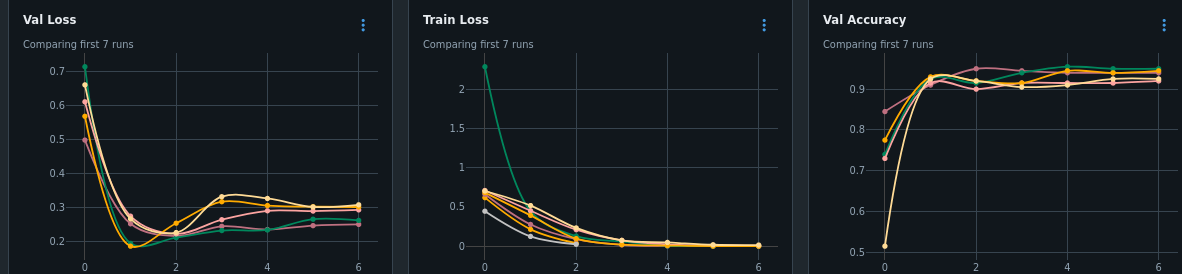

Next step is to train this architecture on the whole train+val dataset